# Laboratorio 02
# Práctica 3 (MLP con Keras - Predicción de sufrir un infarto)
## José Antonio Álvarez, Celia Banegas y Javier Pardo - 3ºC
### Preparación de entorno
#### Importar librerías de código

In [ ]:
#Reseteamos las variables, para evitar problemas con valores acumulados
#Importamos las librerias que necesitamos
%reset
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
from sklearn.ensemble import RandomForestClassifier

##### Dataset que se va a utilizar para el entrenamiento

In [ ]:
# Lectura del dataset
dataset = pd.read_csv('infarto.csv', sep=';')

# Eliminar los registros donde 'bmi' es NaN
dataset = dataset.dropna(subset=['bmi'])

# Convertir los valores NaN en el resto de las columnas en 0
dataset.fillna(0, inplace=True)

# Codificar variables categóricas como números float
dataset['edad'] = dataset['edad'].astype('category').cat.codes.astype(float)
dataset['genero'] = dataset['genero'].astype('category').cat.codes.astype(float)
dataset['casado'] = dataset['casado'].astype('category').cat.codes.astype(float)
dataset['trabajo'] = dataset['trabajo'].astype('category').cat.codes.astype(float)
dataset['residencia'] = dataset['residencia'].astype('category').cat.codes.astype(float)
dataset['uso_tabaco'] = dataset['uso_tabaco'].astype('category').cat.codes.astype(float)
dataset['hipertensión'] = dataset['hipertensión'].astype('category').cat.codes.astype(float)
dataset['enfermedad_coronaria'] = dataset['enfermedad_coronaria'].astype('category').cat.codes.astype(float)

# Mostrar las primeras filas del dataset para verificar
print(dataset.head())


      id  genero   edad  hipertensión  enfermedad_coronaria  casado  trabajo  \
0   9046     1.0   88.0           0.0                   1.0     1.0      3.0   
2  31112     1.0  101.0           0.0                   1.0     1.0      3.0   
3  60182     0.0   70.0           0.0                   0.0     1.0      3.0   
4   1665     0.0  100.0           1.0                   0.0     1.0      0.0   
5  56669     1.0  102.0           0.0                   0.0     1.0      3.0   

   residencia  nivel_glucosa   bmi  uso_tabaco  infarto  
0         1.0         228.69  36.6         0.0        1  
2         0.0         105.92  32.5         3.0        1  
3         1.0         171.23  34.4         1.0        1  
4         0.0         174.12  24.0         3.0        1  
5         1.0         186.21  29.0         0.0        1  


##### Eliminamos las columnas del dataset que no sean necesarias para hacer la predicción
Para identificar la columnas que no sean necesarias para hacer la predicción, construimos una matriz de correlación con todos los valores del dataset donde se mostrará graficamente las variables que estén altamente correlacionadas.

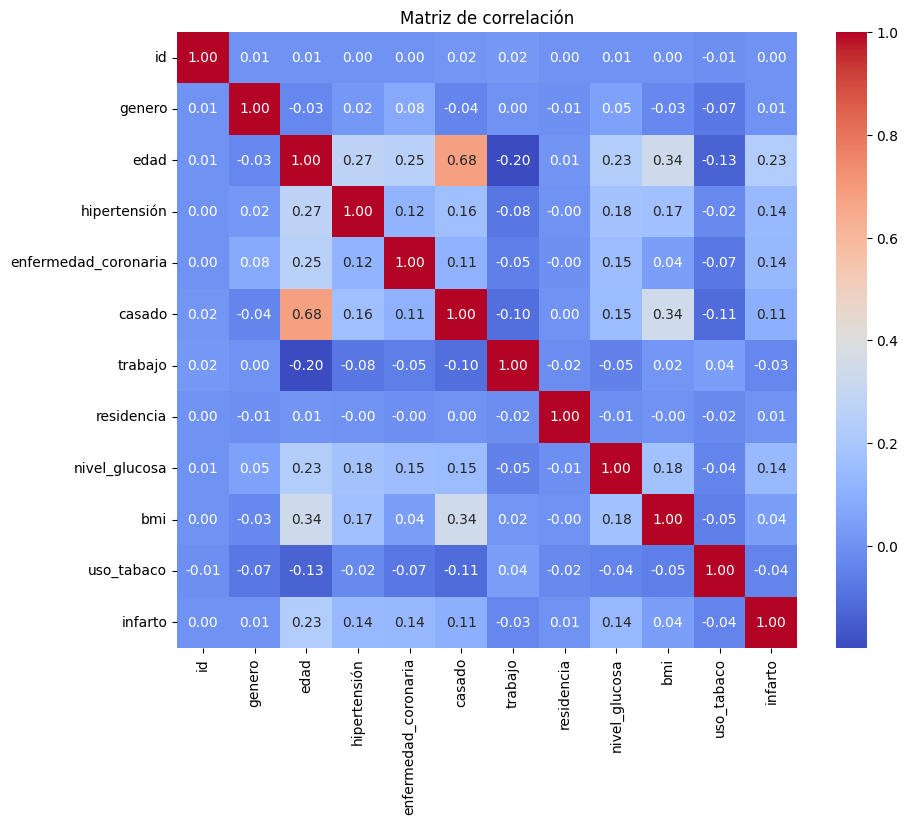

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = dataset.corr()

# Visualizar la matriz de correlación utilizando seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

In [ ]:
# Eliminar las columnas no necesarias
dataset.drop('id', axis=1, inplace=True)
dataset.drop('casado', axis=1, inplace=True)

# Contando cuántos registros tienen un valor de 1.0 en la columna 'infarto'
num_infartos = (dataset['infarto'] == 1.0).sum()
num_SinInfartos = (dataset['infarto'] == 0.0).sum()

print(f'Número de registros con un infarto: {num_infartos}')
print(f'Número de registros sin infarto: {num_SinInfartos}')

if  (num_SinInfartos - num_infartos) - 100 > 0:
    indices_registros_sin_infarto = dataset[dataset['infarto'] == 0.0].index.tolist()
    indices_eliminar = random.sample(indices_registros_sin_infarto, (num_SinInfartos - num_infartos) - 100)
    dataset = dataset.drop(indices_eliminar)

# Ahora el DataFrame está equilibrado
print("Número de registros sin infarto después de equilibrar:", dataset[dataset['infarto'] == 0.0].shape[0])

# Mostrar el dataset con las modificaciones realizadas
dataset

Número de registros con un infarto: 209
Número de registros sin infarto: 4700
Número de registros sin infarto después de equilibrar: 309


,genero,edad,hipertensión,enfermedad_coronaria,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto
0,1.0,88.0,0.0,1.0,3.0,1.0,228.69,36.6,0.0,1
2,1.0,101.0,0.0,1.0,3.0,0.0,105.92,32.5,3.0,1
3,0.0,70.0,0.0,0.0,3.0,1.0,171.23,34.4,1.0,1
4,0.0,100.0,1.0,0.0,0.0,0.0,174.12,24.0,3.0,1
5,1.0,102.0,0.0,0.0,3.0,1.0,186.21,29.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
5041,1.0,74.0,0.0,0.0,3.0,0.0,175.92,26.9,1.0,0
5050,1.0,26.0,0.0,0.0,2.0,1.0,101.87,19.3,2.0,0
5057,0.0,70.0,0.0,0.0,1.0,1.0,69.92,47.6,3.0,0
5069,0.0,42.0,0.0,0.0,3.0,1.0,91.01,28.7,3.0,0


##### División del dataset para realizar el entrenamiento y las pruebas
Separamos los datos en dos conjuntos, siendo uno de prueba con el 20% de los datos originales, y otro de entrenamiento con el 80% de los datos originales.

In [ ]:
# Dividimos el conjunto de datos en conjuntos de prueba y entrenamiento
conjunto_prueba = dataset.sample(frac=0.2, random_state=200)
conjunto_entrenamiento = dataset.drop(conjunto_prueba.index)

# Separamos las características y las etiquetas para el conjunto de prueba
entrada_prueba = conjunto_prueba.drop(columns=['infarto'])
salida_prueba = conjunto_prueba['infarto']

# Separamos las características y las etiquetas para el conjunto de entrenamiento
entrada_entrenamiento = conjunto_entrenamiento.drop(columns=['infarto'])
salida_entrenamiento = conjunto_entrenamiento['infarto']

# Dividimos el conjunto de entrenamiento en conjuntos de entrenamiento y validación
entrada_entrenamiento, entrada_val, salida_entrenamiento, bank_data_salida_val = train_test_split(entrada_entrenamiento, salida_entrenamiento, test_size=0.2, random_state=100)

# Mostramos los tamaños de los conjuntos de datos
print('Tamaño de entrada_entrenamiento:', len(entrada_entrenamiento))
print('Tamaño de entrada_val:', len(entrada_val))
print('Tamaño de salida_entrenamiento:', len(salida_entrenamiento))
print('Tamaño de bank_data_salida_val:', len(bank_data_salida_val))


Tamaño de entrada_entrenamiento: 331
Tamaño de entrada_val: 83
Tamaño de salida_entrenamiento: 331
Tamaño de bank_data_salida_val: 83


##### Entrenamiento del modelo

In [ ]:
# Etiquetación
X = dataset.drop(columns=['infarto'])
y = dataset['infarto']

# División de los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# Hiperparámetros de entrenamiento
neuronas_ocultas_range = range(16, 20)  # Número de neuronas ocultas
capas_ocultas_range = range(2, 5)  # Número de capas ocultas, ahora como hiperparámetro
epochs = 200  # Número de épocas
lr_range = [0.005, 0.05, 0.5]  # Tasa de aprendizaje

results = []  # Lista para almacenar los resultados

# Bucle para iterar con los distintos valores que toman los hiperparámetros en el entrenamiento
for neuronas_ocultas in neuronas_ocultas_range:
    for lr in lr_range:
        for num_capas in capas_ocultas_range:
            print(f"Configurando modelo con {neuronas_ocultas} neuronas, {num_capas} capas ocultas, LR {lr}")

            # Inicialización del modelo
            model = Sequential()
            model.add(Input(shape=(X_train.shape[1],)))  # Capa de entrada
            # Añadir capas ocultas según el número definido
            for _ in range(num_capas):
                model.add(Dense(neuronas_ocultas, activation='relu'))

            model.add(Dense(1, activation='sigmoid'))  # Capa de salida

            # Compilar el modelo
            model.compile(optimizer=Adam(learning_rate=lr), loss='mse', metrics=['accuracy'])

            # Entrenamiento del modelo
            history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=10, verbose=0)

            # Evaluar el modelo
            loss_e, accuracy_e = model.evaluate(X_train, y_train, verbose=0)
            loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=0)

            # Agregar los resultados al registro
            results.append({
                'Nº Neuronas': neuronas_ocultas,
                'Nº Capas': num_capas,
                'Epochs': epochs,
                'η': lr,
                'Loss E': loss_e,
                'Accuracy E': accuracy_e,
                'Loss V': loss_v,
                'Accuracy V': accuracy_v,
            })

# Convertir los resultados a DataFrame para una mejor visualización
results_df = pd.DataFrame(results)
results_df.to_csv('resultadosEntrenamiento.csv', sep=';', index=False)
print(results_df)

Configurando modelo con 16 neuronas, 2 capas ocultas, LR 0.005
Configurando modelo con 16 neuronas, 3 capas ocultas, LR 0.005
Configurando modelo con 16 neuronas, 4 capas ocultas, LR 0.005
Configurando modelo con 16 neuronas, 2 capas ocultas, LR 0.05
Configurando modelo con 16 neuronas, 3 capas ocultas, LR 0.05
Configurando modelo con 16 neuronas, 4 capas ocultas, LR 0.05
Configurando modelo con 16 neuronas, 2 capas ocultas, LR 0.5
Configurando modelo con 16 neuronas, 3 capas ocultas, LR 0.5
Configurando modelo con 16 neuronas, 4 capas ocultas, LR 0.5
Configurando modelo con 17 neuronas, 2 capas ocultas, LR 0.005
Configurando modelo con 17 neuronas, 3 capas ocultas, LR 0.005
Configurando modelo con 17 neuronas, 4 capas ocultas, LR 0.005
Configurando modelo con 17 neuronas, 2 capas ocultas, LR 0.05
Configurando modelo con 17 neuronas, 3 capas ocultas, LR 0.05
Configurando modelo con 17 neuronas, 4 capas ocultas, LR 0.05
Configurando modelo con 17 neuronas, 2 capas ocultas, LR 0.5
Config

##### Buscamos los mejores resultados del entrenamiento

In [ ]:
# Encontrar el índice de la mejor ejecución basada en la métrica deseada, aquí usamos 'Accuracy V'
best_index = results_df['Accuracy V'].idxmax()

# Extraer la fila correspondiente al mejor rendimiento
best_settings = results_df.loc[best_index]

# Imprimir los mejores hiperparámetros y su rendimiento
print("Mejores Hiperparámetros:")
print(f"Número de Neuronas: {best_settings['Nº Neuronas']}")
print(f"Número de capas ocultas: {best_settings['Nº Capas']}")
print(f"Tasa de Aprendizaje: {best_settings['η']}")
print(f"Precisión de Validación: {best_settings['Accuracy V']}")

Mejores Hiperparámetros:
Número de Neuronas: 19.0
Número de capas ocultas: 4.0
Tasa de Aprendizaje: 0.005
Precisión de Validación: 0.7596153616905212


##### Volvemos a hacer un entrenamiento con los mejores hiperparámetros detectados anteriormente

Configurando modelo con 19 neuronas, LR 0.005


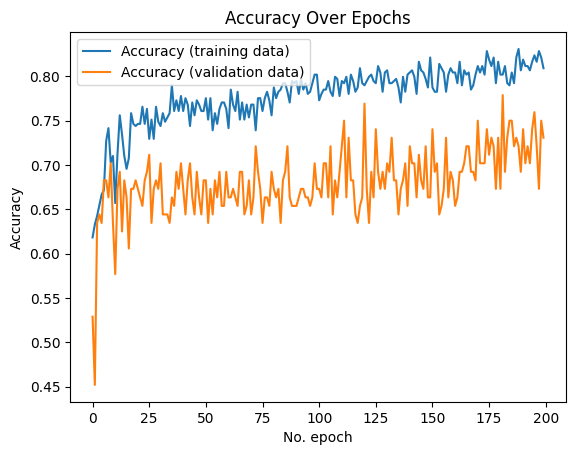

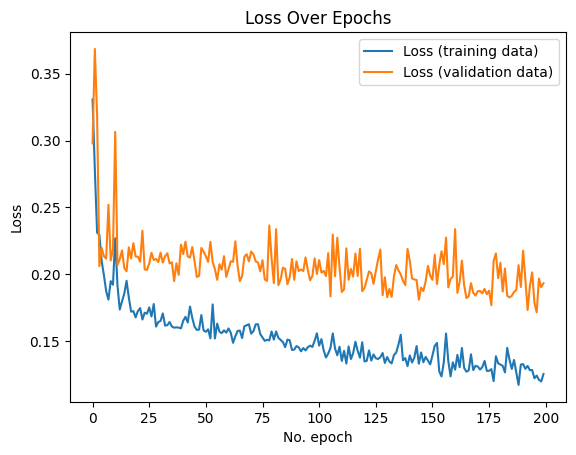

In [ ]:
neuronas_ocultas2 = 19  # Número de neuronas ocultas
epochs2 = 200  # Número de épocas
lr2 = 0.005  # Tasa de aprendizaje

print(f"Configurando modelo con {neuronas_ocultas2} neuronas, LR {lr2}")

# Inicialización del modelo
model2 = Sequential()
model2.add(Input(shape=(X_train.shape[1],)))  # Capa de entrada
# Añadir capas ocultas según el número definido
model2.add(Dense(neuronas_ocultas2, activation='relu'))
model2.add(Dense(neuronas_ocultas2, activation='relu'))
model2.add(Dense(neuronas_ocultas2, activation='relu'))
model2.add(Dense(neuronas_ocultas2, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))  # Capa de salida

# Compilar el modelo
model2.compile(optimizer=Adam(learning_rate=lr2), loss='mse', metrics=['accuracy'])

# Entrenamiento del modelo
history2 = model2.fit(X_train, y_train, epochs=epochs2, validation_data=(X_val, y_val), batch_size=10, verbose=0)

# Evaluar el modelo
loss_e2, accuracy_e2 = model2.evaluate(X_train, y_train, verbose=0)
loss_v2, accuracy_v2 = model2.evaluate(X_val, y_val, verbose=0)


# Gráficas de precisión y pérdida
plt.plot(history2.history['accuracy'], label='Accuracy (training data)')
plt.plot(history2.history['val_accuracy'], label='Accuracy (validation data)')
plt.title('Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.plot(history2.history['loss'], label='Loss (training data)')
plt.plot(history2.history['val_loss'], label='Loss (validation data)')
plt.title('Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

##### Realizamos la predicción de la salida

In [ ]:
bank_data_salida_prediccion = model2.predict(X_train)

#bank_data_salida_prediccion
y_train.to_csv('salida.csv', index=False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step
Matriz de Confusión:
[[48 12]
 [16 28]]


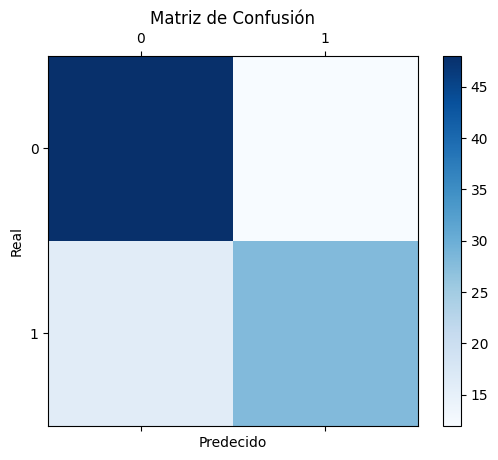

In [ ]:
# Predecir las etiquetas de los datos de validación
y_pred = (model2.predict(X_val) > 0.5).astype("int32")

# Calcular la matriz de confusión
conf_mat = confusion_matrix(y_val, y_pred)

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(conf_mat)

fig, ax = plt.subplots()
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
fig.colorbar(cax)

plt.xlabel('Predecido')
plt.ylabel('Real')
plt.show()

##### Buscamos las variables más importantes a la hora de que nuestro modelo prediga un infarto
A través del algotimo Random Forest se realiza dicha evaluación

In [ ]:
# Crear y entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# Creación del DataFrame de importancias de las características
feature_importances_df = pd.DataFrame({
    'característica': X_train.columns,
    'importancia': model.feature_importances_
}).sort_values(by='importancia', ascending=False)

print(feature_importances_df)
feature_importances_df.to_csv('importanciaCaracteristicas.csv', sep=';', index=False)



         característica  importancia
1                  edad     0.402587
6         nivel_glucosa     0.211675
7                   bmi     0.174504
8            uso_tabaco     0.056744
4               trabajo     0.040145
2          hipertensión     0.039399
5            residencia     0.028361
0                genero     0.025421
3  enfermedad_coronaria     0.021163
